<a href="https://colab.research.google.com/github/IlvirH/telegram-bot-photo/blob/main/08_04_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Фаза 2 • Неделя 8 • Четверг
## Нейронные сети
### 🔥 PyTorch: fine tuning

### Подготовка к работе

1. Загрузи этот ноутбук на Google Colab
2. Авторизируйся на kaggle и выполни все шаги [инструкции](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/)
3. Загрузи датасет по ссылкам ниже

Если не получается авторизироваться или скачать датасет: 
1. Скачай его локально и загрузи на свой Google Drive
2. Подключи свой Google Drive в Google Colab по [инструкции](https://www.marktechpost.com/2019/06/07/how-to-connect-google-colab-with-google-drive/)
3. Перемести файлы в локальное хранилище Colab
4. Разархивировать файлы можно командой `!unzip filename.zip`


Некоторые датасеты можно скачать напрямую с помощью команды `wget`

## Данные

### Датасет: __коты__ и __собаки__

**Ссылка**: [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats)

**Загрузка**: 
    
`
!wget --no-check-certificate \
https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \ 
cats_and_dogs_filtered.zip
`
Если отсутствует `wget` или ОС Windows, то датасет можно скачать по ссылке: [link](https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip)






In [31]:

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import transforms as T
from torchvision import io
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt
import os

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!wget -O cats_and_dogs_filtered.zip https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2023-05-25 16:09:23--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 142.250.107.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   209MB/s    in 0.3s    

2023-05-25 16:09:23 (209 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [25]:
!unzip cats_and_dogs_filtered.zip

Archive:  cats_and_dogs_filtered.zip
replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [34]:
! kaggle datasets download https://www.kaggle.com/competitions/dogs-vs-cats

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


2. Убедитесь, что структура папок соответствует задаче классификации (либо приведите ее к формату, указанному ниже): 

        `train`
        
            - class_1
            - class_2
            - ...
            - class_n
            
        `valid`

            - class_1
            - class_2
            - ...
            - class_n

In [36]:
import os

dataset_path = 'cats_and_dogs_filtered'

train_dir = os.path.join(dataset_path, 'train')
validation_dir = os.path.join(dataset_path, 'validation')

classes = os.listdir(train_dir)

print('Number of classes:', len(classes))

for cls in classes:
    cls_train_path = os.path.join(train_dir, cls)
    cls_validation_path = os.path.join(validation_dir, cls)
    
    print('Class:', cls)
    print('Number of training samples:', len(os.listdir(cls_train_path)))
    print('Number of validation samples:', len(os.listdir(cls_validation_path)))

Number of classes: 2
Class: dogs
Number of training samples: 1000
Number of validation samples: 500
Class: cats
Number of training samples: 1000
Number of validation samples: 500


1. Создайте `DataLoader` в для обучающей и валидационных выборок. Примените аугментации к изображениям. 

In [37]:
data_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
    ]
)

In [38]:
import torchvision
train_dataset = torchvision.datasets.ImageFolder('cats_and_dogs_filtered/train/', 
                                                 transform=data_transforms)
valid_dataset = torchvision.datasets.ImageFolder('cats_and_dogs_filtered/validation/', 
                                                 transform=data_transforms)

In [39]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

На картинке ниже изображена сеть Inception v1. Для чего в её архитектуре присутствуют сразу 3 выхода? Как происходит инференс (предсказание) с помощью этой сети? 

![](https://miro.medium.com/max/1400/1*uW81y16b-ptBDV8SIT1beQ.png)

> ответ тут

4. Создайте экземпляр предобученной модели: [torchvision models](https://pytorch.org/vision/stable/models.html)

In [128]:
import torchvision.models as models

# Загрузка предобученной модели ResNet50
model = models.resnet50(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


5. Дополните модель выходым слоем формата, который подходит под задачу: бинарная или многоклассовая классификация. 

In [129]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [144]:
import torch.nn as nn
model.fc = nn.Linear(2048, 1)


In [163]:
model_1 = models.resnet50(pretrained=True)
model_1.fc = nn.Linear(2048, 1)

6. Обучите модель (только последний слой!) и зафиксируйте метрику на валидационной части выборки. 

In [145]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.BCEWithLogitsLoss()

In [146]:
# замораживаем все веса в модели
for param in model.parameters():
    param.requires_grad = False

model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

7. Распечатайте изображение из тестовой выборки и подпишите класс картинки, предсказанный моделью. 

In [147]:
def compute_batch_accuracy(preds, labels):
    preds_reshaped = preds.squeeze(-1)
    # print(preds_reshaped)
    preds_sigmoid  = preds_reshaped.sigmoid()
    # print(preds_sigmoid)
    preds_classes  = torch.round(preds_sigmoid)
    # print(preds_classes)
    bool_array     = preds_classes == labels
    # print(bool_array)
    number_of_true = bool_array.sum()
    # print(number_of_true)
    accuracy       = number_of_true / len(labels)
    # print(accuracy)
    accuracy_float = accuracy.item()

    return accuracy_float

In [148]:
 def fit(model: torch.nn.Module, n_epochs: int = 30):
    model.to(device)

    train_epoch_acc = []
    train_epoch_losses = []
    valid_epoch_losses = []
    valid_epoch_acc =[]
    for epoch in range(n_epochs):
        model.train()
        loss_batch = []
        acc_batch  = []



        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)
            
            loss = criterion(preds.squeeze(-1), labels.float())

            loss_batch.append(loss.item())
            acc_batch.append(compute_batch_accuracy(preds, labels))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_epoch_losses.append(np.mean(loss_batch))
        train_epoch_acc.append(np.mean(acc_batch))
        
        model.eval()
        loss_batch = []
        acc_batch  = []
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)

            loss_batch.append(loss.item())
            acc_batch.append(compute_batch_accuracy(preds, labels))

            
        valid_epoch_losses.append(np.mean(loss_batch))
        valid_epoch_acc.append(np.mean(acc_batch))
        print(f'[Epoch {epoch:02d}] Train loss: {train_epoch_losses[-1]:.4f}, valid loss = {valid_epoch_losses[-1]:.4f} Train acc {train_epoch_acc[-1]:.4f} Valid acc {valid_epoch_acc[-1]:.4f}')
        
    fig, ax = plt.subplots(1, 2, figsize=(20, 4))
    ax[0].plot(train_epoch_losses)
    ax[0].plot(valid_epoch_losses)
    ax[0].set_ylim((0, np.max(train_epoch_losses.extend(valid_epoch_losses))))
    ax[0].set_title('Valid loss history')

    ax[1].plot(train_epoch_acc)
    ax[1].plot(valid_epoch_acc)
    ax[1].set_ylim(0, 1.1)
    ax[1].set_title('Acc history');
    return train_epoch_acc, train_epoch_losses, valid_epoch_losses, valid_epoch_acc

[Epoch 00] Train loss: 0.1823, valid loss = 0.3624 Train acc 0.9628 Valid acc 0.9873
[Epoch 01] Train loss: 0.1143, valid loss = 0.3727 Train acc 0.9633 Valid acc 0.9902
[Epoch 02] Train loss: 0.0859, valid loss = 0.0849 Train acc 0.9742 Valid acc 0.9883
[Epoch 03] Train loss: 0.0784, valid loss = 0.1497 Train acc 0.9752 Valid acc 0.9824
[Epoch 04] Train loss: 0.0727, valid loss = 0.0276 Train acc 0.9752 Valid acc 0.9814


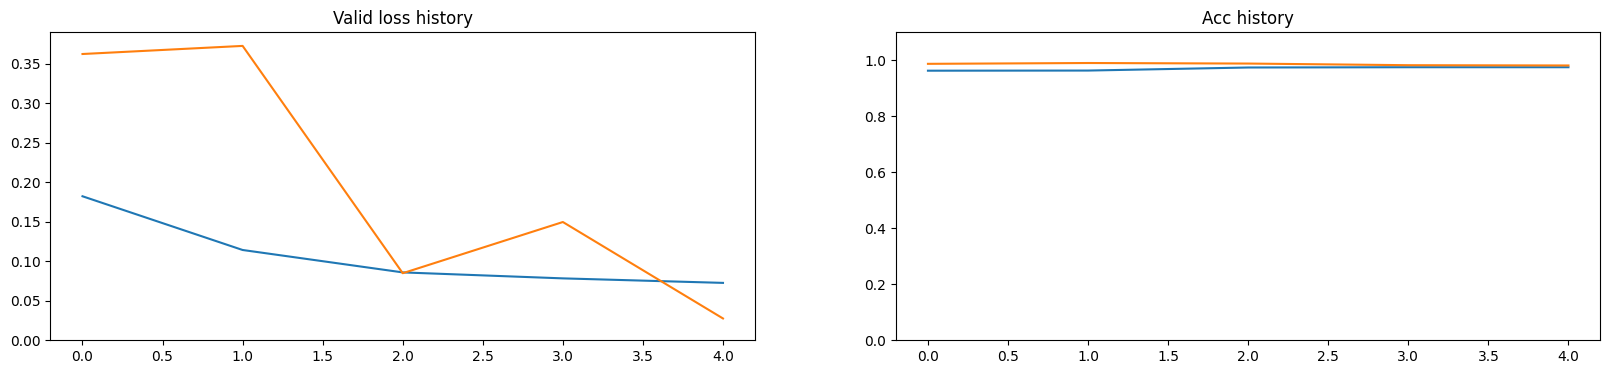

In [150]:
train_epoch_acc, train_epoch_losses, valid_epoch_losses, valid_epoch_acc = fit(model, 5)

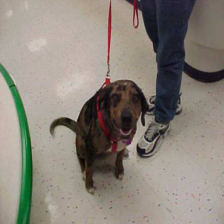

Predicted Class: Class 1
True Class: Class 1


In [151]:
# Выбираем случайное изображение из тестовой выборки
image, label = next(iter(valid_loader))
image = image[0]  # Извлекаем единственное изображение из батча
label = label[0]  # Извлекаем соответствующий класс

# Прогнозирование класса изображения
with torch.no_grad():
    output = model(image.unsqueeze(0).cuda())  # Добавляем размерность батча и указываем использование Cuda
    predicted = torch.round(torch.sigmoid(output))

# Подписываем класс картинки
class_names = ["Class 0", "Class 1"]  # Замените на свои классы
predicted_class = class_names[int(predicted.item())]
true_class = class_names[int(label.item())]

# Отображение изображения и его подписи
image = transforms.ToPILImage()(image.cuda())  # Указываем использование Cuda
image.show()
print(f"Predicted Class: {predicted_class}")
print(f"True Class: {true_class}")

In [152]:
!wget -O image3.jpg https://klike.net/uploads/posts/2018-10/1539499416_1.jpg

--2023-05-25 17:46:55--  https://klike.net/uploads/posts/2018-10/1539499416_1.jpg
Resolving klike.net (klike.net)... 172.67.189.152, 104.21.89.158, 2606:4700:3035::6815:599e, ...
Connecting to klike.net (klike.net)|172.67.189.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40895 (40K) [image/jpeg]
Saving to: ‘image3.jpg’

image3.jpg          100%[===================>]  39.94K  --.-KB/s    in 0.002s  

2023-05-25 17:46:55 (19.3 MB/s) - ‘image3.jpg’ saved [40895/40895]



In [153]:
resize = T.Resize((224, 224))
img = resize(io.read_image('image3.jpg')/255)
img.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 224, 224])

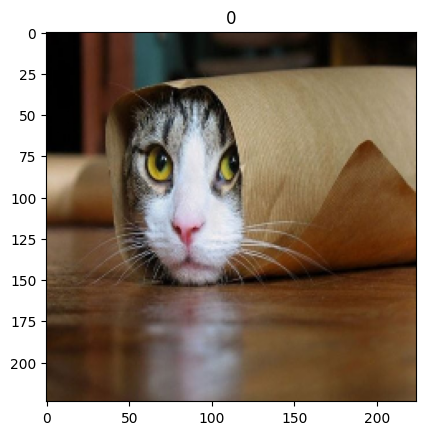

In [154]:
img = resize(io.read_image('image3.jpg')/255)
model.to(device)
model.eval()
plt.imshow(torch.permute(img, (1, 2, 0)))
plt.title(model(img.to(device).unsqueeze(0)).argmax().item());

8. "Разморозьте" несоклько слоев базовой модели и вновь обучите ее. Зафиксируйте метрику качества для модели. О том, как сделать unfreeze нескольких слоев сразу, а не только последнего, можно почитать тут: [discuss.pytorch.org](https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088/3)

In [166]:
for param in model_1.parameters():
    param.requires_grad = False

for param in model_1.layer4.parameters():
    param.requires_grad = True

# for param in model_1.layer3.parameters():
#     param.requires_grad = True  

model_1.fc.weight.requires_grad = True
model_1.fc.bias.requires_grad = True 

[Epoch 00] Train loss: 0.6764, valid loss = 0.6760 Train acc 0.5675 Valid acc 0.5996
[Epoch 01] Train loss: 0.6787, valid loss = 0.6883 Train acc 0.5625 Valid acc 0.6006
[Epoch 02] Train loss: 0.6764, valid loss = 0.6722 Train acc 0.5620 Valid acc 0.6025
[Epoch 03] Train loss: 0.6769, valid loss = 0.6448 Train acc 0.5749 Valid acc 0.6016
[Epoch 04] Train loss: 0.6782, valid loss = 0.7095 Train acc 0.5640 Valid acc 0.6025
[Epoch 05] Train loss: 0.6778, valid loss = 0.6909 Train acc 0.5615 Valid acc 0.6123
[Epoch 06] Train loss: 0.6786, valid loss = 0.6713 Train acc 0.5585 Valid acc 0.6006


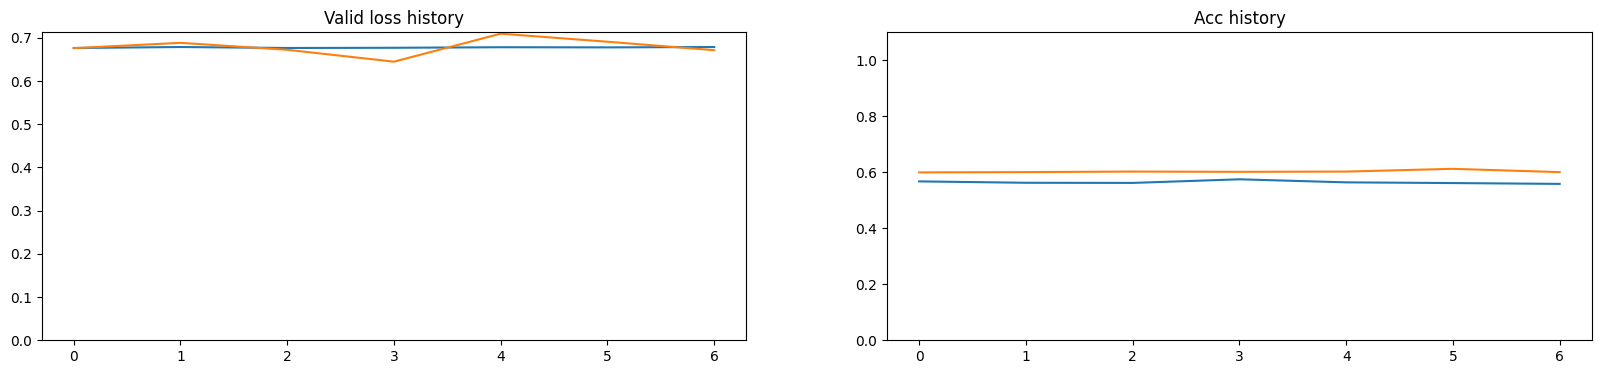

In [167]:
model_1.to(device)
train_epoch_acc1, train_epoch_losses1, valid_epoch_losses1, valid_epoch_acc1 = fit(model_1, 7)

9. Сравни качество двух моделей: предобученной с замененным выходным слоем и дообученной с несколькими размороженными слоями. 

<img src="https://icons.iconarchive.com/icons/icons8/windows-8/256/Programming-Github-icon.png" width=32 /> Сохрани файл для __github__ и распечатай результат команды `!git status` в ячейке ниже. 

In [ ]:
# code

10. Сохрани модель (пример можно посмотреть [тут](../../learning/aux/model_saving.ipynb) или в [документации](https://pytorch.org/tutorials/beginner/saving_loading_models.html))

In [ ]:
torch.save(model.state_dict(), 'model.pth')

11. Реализуй функцию, которая на вход принимает путь к файлу, а в ответ возвращает класс объекта. 

In [ ]:
def get_prediction(path: str) -> str:
    pass

12. Сохрани ноутбук на github

13. Реализуй telegram-бот, которому пользователь присылает картинку, а бот возвращает пользователю класс объекта, котороый изображен на картинке. 